# TIME SERIES ANALYSIS OF GOOGLE TRENDS DATA
Objective:
Based on how often the word 'pandas' has been googled worldwide in the past 5 years, how often will it likely be googled in the future? 

## 1. Import the standard libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
#%matplotlib inline

from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")

## 2. Source the data


We need to read the csv-file into pandas as a dataframe. The function to call is .read_csv('name_of_file') in this case. We call our dataframe df for convenience.

In [2]:
df = pd.read_csv('pandas.csv')

## 3. Explore & transform the data

In [3]:
df.head(5)


,Category: All categories
Week,pandas: (Worldwide)
2015-03-08,13
2015-03-15,13
2015-03-22,13
2015-03-29,13


We can see above that the intended column names 'Week' and 'pandas (Worldwide)' are actually the first row (i.e. data point) in the dataset.
The intended first column 'Week' is being considered the index. This can be seen from the bold font. Let's see if this suspicion is correct by obtaining more .info() about the dataframe.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 262 entries, Week to 2020-03-01
Data columns (total 1 columns):
Category: All categories    262 non-null object
dtypes: object(1)
memory usage: 4.1+ KB


Our suspicion is correct, we only have a total of 1 column, which is called 'Category: All categories' and contains 261 datapoints (I.e., rows). Additionally, since the data we pulled contains the weekly data over 5 years, or 5x52=260 Weeks, we should only have 260 rows (or non-null objects), confirming that 'Week' and 'vegan: (Worldwide)' are actually considered the first data point in our dataframe, instead of being the column labels as was intended.
<br>
We can remedy that issue by skipping the first row when reading the csv-file into pandas as a dataframe. 

In [6]:
df = pd.read_csv('pandas.csv',skiprows=1)
df.head()

,Week,pandas: (Worldwide)
0,2015-03-08,13
1,2015-03-15,13
2,2015-03-22,13
3,2015-03-29,13
4,2015-04-05,12


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 2 columns):
Week                   261 non-null object
pandas: (Worldwide)    261 non-null int64
dtypes: int64(1), object(1)
memory usage: 4.2+ KB


Our data now looks as intended, containing two columns labeled 'Week' and 'pandas: (Worldwide)' which in turn consist of 260 datapoints. However, the first column 'Week' contains object data-types, not dates. Could this possibly be a problem? One way to find out is by trying to plot the dataframe df and see what happens:

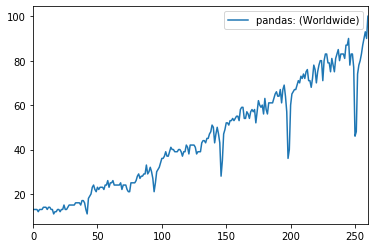

In [8]:
df.plot()

We can identify a problem with the x-axis: The first column is indeed not recognised as a date, but as a string, hence its data-type above is given as an object. 
Therefore, the x-axis is just the index ranging from 0 to 259, printed in bold font. Then the first column is skipped because it does not contain any numerical values, and the second column is plotted.

Hence, our next step is to change the data-type of the first column to a date and afterwards replacing the index of the dataframe with the corresponding dates contained in the first column.


In [9]:
df['Week'] = pd.to_datetime(df['Week']) #Change the data-type of the column's entries to datetime. 
df.set_index('Week', inplace = True) #Replace the index of the dataframe df by the dates contained in the first column

#Check datatype of index
df.index

DatetimeIndex(['2015-03-08', '2015-03-15', '2015-03-22', '2015-03-29',
               '2015-04-05', '2015-04-12', '2015-04-19', '2015-04-26',
               '2015-05-03', '2015-05-10',
               ...
               '2019-12-29', '2020-01-05', '2020-01-12', '2020-01-19',
               '2020-01-26', '2020-02-02', '2020-02-09', '2020-02-16',
               '2020-02-23', '2020-03-01'],
              dtype='datetime64[ns]', name='Week', length=261, freq=None)

The index of the dataframe is now recognised to be a date. The index label has been changed to be 'Week'. What are the advantages? For example, take a range of dates in compact form, such as:

In [10]:
df['12-2018']

,pandas: (Worldwide)
Week,
2018-12-02,69
2018-12-09,64
2018-12-16,57
2018-12-23,36
2018-12-30,40


Additionally, instead of using a DataFrame, we can just as easily define a Series, which is essentially a single column dataframe, much like a vector is a single column version of a matrix. Since our Series is supposed to be a timeseries, we choose to call our variable ts. We can see above that the column label of the dataframe is 'pandas: (Worldwide)', which contains the entries of the Series we want to convert our dataframe into.

In [12]:
pandas_ts = df['pandas: (Worldwide)']
pandas_ts.head()

Week
2015-03-08    13
2015-03-15    13
2015-03-22    13
2015-03-29    13
2015-04-05    12
Name: pandas: (Worldwide), dtype: int64

What we have our data transformed into is a Series in the pandas library whose index is of the date data-type given by the week-dates. The same values as by df['12-2018'] above (please compare!) can be returned via:

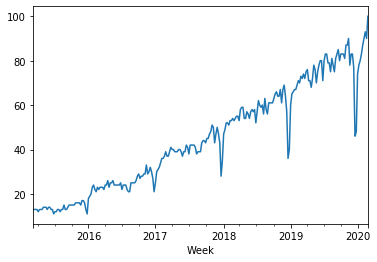

In [14]:
pandas_ts.plot()

## 4. Data Analysis to Find ARIMA(p,d,q)-parameters

### GOAL: Trying to recreate the vegan dataset. <BR>

Set up the skeleton and then put values of dates and pandas-searches to fit that skeleton to replicate the dataset by via a mathematical equation!

#### 4.1. Decomposition
As further analysis of our dataset, we would like to find the decomposition that makes up the 'vegan' data. 

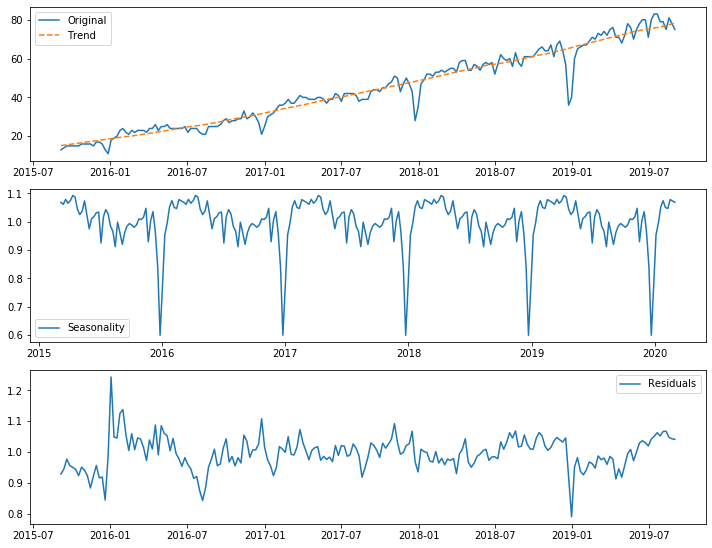

In [16]:
decomposition = seasonal_decompose(pandas_ts, model='multiplicative', freq=52)
# Model can be chosen to be multiplicative or additive. 
# Since additive is linear it would mean the seasonality/residuals do not increase with
# the trend. However, as can be seen in the original data, as well as it is a common 
# assumption with internet searches, the more people google something the higher the 
# fluctuations will be as well. Therefore we choose 'multiplicative' here. 


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10,10))

plt.figure(1)
plt.subplot(411)
plt.plot(trend*seasonal*residual, label = 'Original')
plt.plot(trend, label = 'Trend',linestyle='--')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

We can see from this decomposition analysis that the original data is made up of a general underlying trend, a seasonal component that repeats itself for each year (defined by freq=52), and a non-systematic residual component.

#### 4.2. (Partial) Autocorrelation Function
How much is the data correlated with itself?<br>

https://stats.stackexchange.com/questions/44992/what-are-the-values-p-d-q-in-arima <br>

Last page of this document explains how to find the p- and q-parameters from the ACF and PACF. <br>
The combination of AR(p) and MA(q) can lead to slight changes in the parameters but this could be done by a gridsearch trying to minimise the AIC.
###### Akaike Information Critera

We need to find the parameters (p,d,q) 

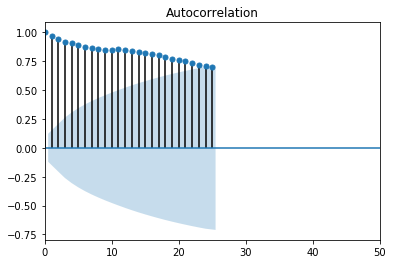

In [17]:
plot_acf(pandas_ts)
plt.xlim(0,50)
plt.show()

The data is non-stationary. We need to apply first order differencing. 

<font color='red'>================================</font> <br>
<font color='red'> ==>> d=1 <<== (first order of differencing) </font>  <br>
<font color='red'>================================</font>

This makes the data stationairy, i.e., we remove the trend. <br>
This information will be important when we define our model.

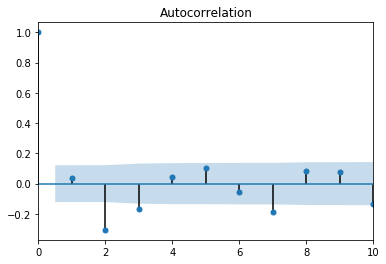

In [18]:
plot_acf(pandas_ts.diff(1).dropna())
plt.xlim(0,10)
plt.show()

<font color='red'>==================</font> <br>
<font color='red'> ==>> q=1 <<== (lag=q) </font>  <br>
<font color='red'>==================</font>

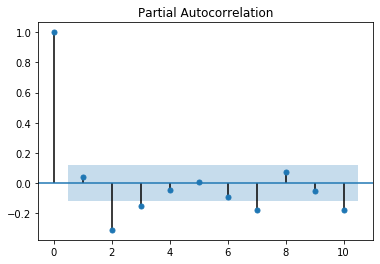

In [19]:
plot_pacf(pandas_ts.diff(1).dropna(), lags=10)
plt.show()

<font color='red'>==================</font> <br>
<font color='red'> ==>> p=2 <<== (lag=p) </font>  <br>
<font color='red'>==================</font>

In [20]:
resDiff = sm.tsa.arma_order_select_ic(pandas_ts, max_ar=3, max_ma=3, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q) = (1, 3) is the best.


# 5. Building the Model

#### 5.1. Train/Test Split

In [21]:
train = pandas_ts[:'06-2018'].dropna()
test = pandas_ts['27-05-2018':].dropna()

#### 5.2. Seasonal ARIMA

In [22]:
model = SARIMAX(train, order=(2,1,1), seasonal_order=(1,1,0,52) # We gridsearched the seasonal parameters
              ,enforce_stationarity=False, enforce_invertibility=False)

In [23]:
results = model.fit()

In [24]:
pred = results.predict(start='06-2018',end='08-2019')[1:]

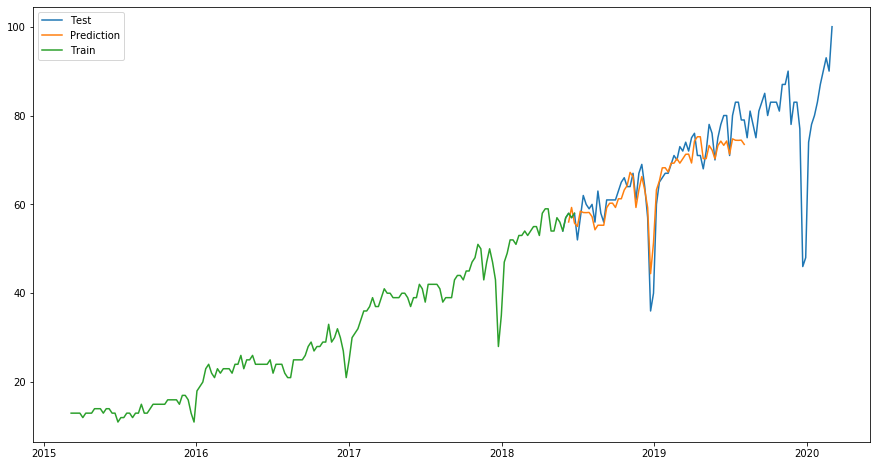

In [25]:
plt.figure(figsize=(15,8))
plt.plot(test,label='Test')
plt.plot(pred,label='Prediction')
plt.plot(train,label='Train')
plt.legend(loc='best')
plt.show()

# 6. Evaluate the Model

In [26]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                pandas: (Worldwide)   No. Observations:                  173
Model:             SARIMAX(2, 1, 1)x(1, 1, 0, 52)   Log Likelihood                -144.365
Date:                            Sun, 08 Mar 2020   AIC                            298.730
Time:                                    19:11:00   BIC                            309.679
Sample:                                03-08-2015   HQIC                           303.056
                                     - 06-24-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5638      0.167      3.373      0.001       0.236       0.891
ar.L2         -0.2807      0.201     -1.399      0.162      -0.674       0.112
ma.L1         -1.0000    574.128     -0.002      0.999   -1126.270    1124.270
ar.S.L52      -0.0136      0.152     -0.089      0.929      -0.312       0.285
sigma2         4.4535   2556.545      0.002      0.999   -5006.283    5015.190
===================================================================================
Ljung-Box (Q):                       53.78   Jarque-Bera (JB):                51.02
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                            -1.03
Prob(H) (two-sided):                  0.50   Kurtosis:                         6.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

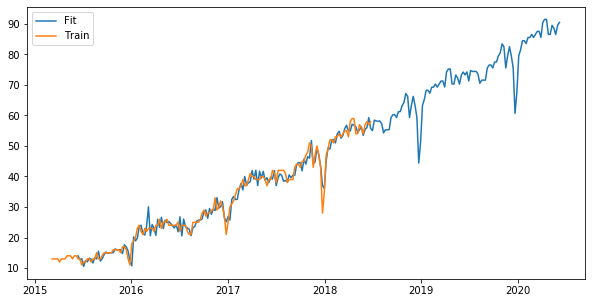

In [30]:
fit = results.predict(start='06-2015',end='06-2020')[1:]
plt.figure(figsize=(10,5))
plt.plot(fit,label='Fit')
plt.plot(train,label='Train')
plt.legend(loc='best')
plt.show()